In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.linalg import qr
import pickle
from tqdm import tqdm
import pywt
#from random import randint

BAD = ['VT', 'VFb', 'VFt'] # KIS,S
project_dir = r'C:\Users\jodge\Documents\School\Summer24\tinymlcontest2022_demo_example'
dir_path = r'C:\Users\jodge\Documents\School\Summer24\tinyml_contest_data_training'
directory_files = os.listdir(dir_path)

training_script = os.path.join(project_dir, 'training_save_deep_models.py')
testing_script = os.path.join(project_dir, 'testing_performances.py')
models_dir = os.path.join(project_dir, 'models')
results_dir = os.path.join(project_dir, 'results')

"""
Energy captured: ranks needed
 5%: 14  10%: 29  15%: 46  20%: 64   25%:  84
30%: 106 35%: 129 40%: 154 45%: 182  50%:  215
55%: 252 60%: 297 65%: 354 70%: 443  75%:  552
80%: 670 85%: 798 90%: 935 95%: 1084 100%: 1250 
"""

'\nEnergy captured: ranks needed\n 5%: 14  10%: 29  15%: 46  20%: 64   25%:  84\n30%: 106 35%: 129 40%: 154 45%: 182  50%:  215\n55%: 252 60%: 297 65%: 354 70%: 443  75%:  552\n80%: 670 85%: 798 90%: 935 95%: 1084 100%: 1250 \n'

In [2]:
label_path = os.path.join(project_dir, 'label_list.csv')
df_labels = pd.read_csv(label_path, sep=',', header=0)
label_dict = {k : v for k,v in df_labels.values}
label_dict

{'AFb': 'Atrial Fibrillation',
 'AFt': 'Atrial Flutter',
 'SR': 'Sinus Rhythm',
 'SVT': 'Supraventricular Tachycardia',
 'VFb': 'Ventricular Fibrillation',
 'VFt': 'Ventricular Flutter',
 'VPD': 'Ventricular Premature Depolarizations',
 'VT': 'Ventricular Tachycardia'}

In [3]:
def readObj(filename):
    print(f"reading from {filename}")
    with open(filename, 'rb') as file:
       return pickle.load(file)
def saveObj(obj, filename):
    print(f"saving to {filename}")
    with open(filename, 'wb') as file:
        pickle.dump(obj, file)        
def getStyle(file_name):
    return 'b-' if file_name.split('-')[1] not in BAD else 'r-'

In [4]:
def setCorrectModel(path, wanted = "original"):
    if wanted == "original":
        #os.rename(os.path.join(path, 'model_1.py.og'), os.path.join(path,'model_1.py'))
        return f"ren {os.path.join(path, 'model_1.py.og')} model_1.py"
    elif wanted == "avgpool":
        #os.rename(os.path.join(path, 'model_1.py.avgpool'), os.path.join(path,'model_1.py'))
        return f"ren {os.path.join(path, 'model_1.py.avgpool')} model_1.py"
        
def resetModel(models_dir, used = "original"):
    if used == "original":
        #os.rename(models_dir, os.path.join(models_dir, 'model_1.py.og'))
        return f"ren {os.path.join(models_dir, 'model_1.py')} model_1.py.og"
    elif used == "avgpool":
        #os.rename(models_dir, os.path.join(models_dir,'model_1.py.avgpool'))
        return f"ren {os.path.join(models_dir, 'model_1.py')} model_1.py.avgpool"
    else:
        print("BAD!!!!!!!!!!!!!")

In [5]:
def batGen(rp, numRuns=5, mode = "normal", sampleRate = 1.0, length = 1250, model = "original", kept = 100):
    ans = []

    recon_indices_dir = os.path.join(project_dir, 'recon_indices\\')
    trunc_indices_dir = os.path.join(project_dir, 'trunc_indices\\')
    drop_indices_dir = os.path.join(project_dir, 'drop_indices\\')
    fft_indices_dir = os.path.join(project_dir, 'fft_indices\\')
    
    data_dir = r'C:\Users\jodge\Documents\School\Summer24'
    recon_data_dir = os.path.join(data_dir, 'recon_data\\')
    trunc_data_dir = os.path.join(data_dir, 'trunc_data\\')
    drop_data_dir = os.path.join(data_dir, 'drop_data\\')
    fft_data_dir = os.path.join(data_dir, 'fft_data\\')

    path_flags = ''
    if mode == 'recon':
        path_flags = f'--path_data {recon_data_dir} --path_indices {recon_indices_dir}'
    elif mode == 'trunc':
        path_flags = f'--path_data {trunc_data_dir} --path_indices {trunc_indices_dir}'
    elif mode == 'drop' or mode == 'random':
        path_flags = f'--path_data {drop_data_dir} --path_indices {drop_indices_dir}'
    elif mode == 'fft':
        path_flags = f'--path_data {fft_data_dir} --path_indices {fft_indices_dir}'
        

    size_flags = ''
    if length < 98:
        length = 98
    if length != 1250:
        if model == 'avgpool':
            size_flags = f'--size {length}'

    sample_flags = f'--sample_rate {sampleRate}' if sampleRate != 1.0 else ''
    sample_flags_temp = f'_{int(sampleRate)}' if sample_flags else ''
    sample_flags_temp.replace('.','-')
    
    temp_kept_flag = '_k'+str(kept) if kept != 100 else ''
    print(sample_flags_temp, temp_kept_flag)

    out_train_name = f'train_{mode}_r{rp}_{length}{sample_flags_temp}_{model}.txt'
    out_test_name = f'TEST_{mode}_r{rp}_{length}{sample_flags_temp}{temp_kept_flag}_{model}.csv'
    output_train_file = os.path.join(results_dir, out_train_name)
    output_test_file = os.path.join(results_dir, out_test_name)

    temp_train_out = 'train_temp.txt'
    temp_test_out = 'test_temp.txt'
    train_command = f'\tpython {training_script} {path_flags} {sample_flags} {size_flags} >> {output_train_file}'
    test_command = f'\tpython {testing_script} {path_flags} {sample_flags} {size_flags} >> {output_test_file}'

    loop_head = r'for /l %%i in (1,1,' + str(numRuns) + r') do ('
    loop_tail = ')'

    ans.append(r'@echo off')
    ans.append(setCorrectModel(models_dir, model))  
    ans.append(loop_head)
    
    ans.append('\techo iteration %%i')
    ans.append(train_command)
    ans.append(test_command)
    
    ans.append(loop_tail)
    ans.append(resetModel(models_dir, model))
    ans.append('pause')
    
    bat_name = out_test_name.split(".")[0]
    bat_name = "_".join(bat_name.split("_")[1:]) + ".bat"

    bat = os.path.join("bats", bat_name)
    with open(bat,"w") as output:
        for line in ans:
            output.write(line + '\n')
    
    return ans, bat_name 

In [6]:
def batGenNew(out_train_name, out_test_name, numRuns = 5, indices_folder = None, data_folder=None, length=1250, model = 'original', additional_flags = ''):
    ans = []

    output_train_file = os.path.join(results_dir, out_train_name)
    output_test_file = os.path.join(results_dir, out_test_name)

    path_flags = ''
    if data_folder:
        data_path = os.path.join(r'C:\Users\jodge\Documents\School\Summer24', data_folder)
        path_flags = path_flags + f' --path_data {data_path}'
    if indices_folder:
        indices_path = os.path.join(project_dir, indices_folder)
        path_flags = path_flags + f' --path_indices {indices_path}'
    #path_flags = f'--path_data {data_path} --path_indices {indices_path}' if indices_folder or data_folder else ''

    size_flags = ''
    if length < 98:
        length = 98
    if length != 1250 and model == 'avgpool':
        size_flags = f'--size {length}'

    train_command = f'\tpython {training_script} {path_flags} {size_flags} {additional_flags} >> {output_train_file}'
    test_command = f'\tpython {testing_script} {path_flags} {size_flags} {additional_flags} >> {output_test_file}'

    loop_head = r'for /l %%i in (1,1,' + str(numRuns) + r') do ('
    loop_tail = ')'

    ans.append(r'@echo off')
    ans.append(setCorrectModel(models_dir, model))  
    ans.append(loop_head)
    
    ans.append('\techo iteration %%i')
    ans.append(train_command)
    ans.append(test_command)
    
    ans.append(loop_tail)
    ans.append(resetModel(models_dir, model))
    ans.append('pause')
    
    bat_name = out_test_name.split(".")[0]
    bat_name = "_".join(bat_name.split("_")[1:]) + ".bat"

    bat = os.path.join("bats", bat_name)
    with open(bat,"w") as output:
        for line in ans:
            output.write(line + '\n')
    
    return bat_name 

# CHOOSE WHAT TO RUN FROM HERE!
### Set your variables and then move the .bat to the right folder and then run it from CMD.

# SVD

In [74]:
def prepareData(problemSetup): #for SVD
    #problemSetupsDir = r'C:\Users\jodge\Documents\School\Summer24\playground\data'
    #problemSetup = readObj(os.path.join(problemSetupsDir, 'full.pkl'))
    print(problemSetup.r, problemSetup.p) # make sure it's working
        
    for fi in tqdm(directory_files[:]): #special iterator that makes a progress bar
        signal = np.loadtxt(os.path.join(dir_path,fi))
        mse, recon = measureAndReconstruct(problemSetup, signal)

        #FOR THE TRUNCATED REPRESENTATION ###############################
        #trunc = problemSetup.C @ temp # not going to do this anymore, we want to preserve the natural ordering / time information

        #with zeroes for where we didn't want info so the signal "looks" like the original
        #trunc = indices_to_zero = np.setdiff1d(np.arange(trunc.size), pivots)
        #np.put(trunc, indices_to_zero, 0)
        
        trunc = signal[sorted(problemSetup.pivots)]
        #FOR THE TRUNCATED REPRESENTATION ###############################

        
        # fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,4))
        # style = getStyle(fi)
        # ax0.plot(recon, style)
        # ax1.plot(trunc, style)
        # plt.show()
        
        outReconName = os.path.join(r'C:\Users\jodge\Documents\School\Summer24\recon_data', 'R' + fi) 
        outTruncName = os.path.join(r'C:\Users\jodge\Documents\School\Summer24\trunc_data', 'T' + fi)
        np.savetxt(outReconName, recon, fmt='%.7f')
        np.savetxt(outTruncName, trunc, fmt='%.7f')
    
    print("DONE")
    return r, p # ive been using p (which should be r+1) for file naming. idk why i chose that convention.

def weird(x_reconstructed):
    largg = 0
    largg_i = 0
    for i, v in enumerate(x_reconstructed):
        v = abs(v)
        if v > largg:
            largg = v
            largg_i = i
    
    return largg_i

In [71]:
class SVD:
    def __init__(self, U, S, VT):
        self.U = U
        self.S = S
        self.VT = VT

class ProblemSetup:
  def __init__(self, r, p, truncSVD, Q, R, pivots, C): #fullSVD,
      self.r = r # ranks to use
      self.p = p # number of sensors
      #self.fullSVD = fullSVD
      self.truncSVD = truncSVD
      self.Q = Q
      self.R = R
      self.pivots = pivots
      self.C = C
      
def getFullTrainSignalMatrix(): #all files with each as a column
    pkl_name = r"fullTrainMat.pkl"
    pkl_loc = os.path.join("data", pkl_name)

    if os.path.exists(pkl_loc):
        answer = readObj(pkl_loc)
        return answer
    else:
        print(f"{pkl_loc} not found - see other notebooks for generation")
        
def processData(trainingData, label, r = 400, p = 500): # r = ranks desired, p = num sensors. bug when r=p, math is hard.
    pkl_name = f"{label}_r{r}_p{p}.pkl"
    pkl_loc = os.path.join("data", pkl_name)

    if os.path.exists(pkl_loc):
        answer = readObj(pkl_loc)
        return answer
    
    U, S, VT = svd(trainingData)
    #full_SVD = SVD(U, S, VT)
    
    #reshape SVD according to r
    U_hat, S_hat, VT_hat = U[:,:r], S[:r,:r], VT[:r,:]
    trunc_SVD = SVD(U_hat, S_hat, VT_hat)
    
    Q, R, pivots = None, None, None
    if (p == r):
        Q, R, pivots = qr(U, pivoting = True) # or maybe just U! - we did this change!
    elif (p > r): # oversampled
        Q, R, pivots = qr(U_hat @ U_hat.T, pivoting = True) # or maybe just U
    else:
        for _ in range(100):
            print("ERROR p < r")
            
    pivots = pivots[:p]
    
    # Create C matrix
    C = np.zeros((p, getFullTrainSignalMatrix().shape[0]))
    #print(C.shape, pivots.shape)
    C[np.arange(p), pivots] = 1

    problemSetup = ProblemSetup(r, p,  trunc_SVD, Q, R, pivots, C) #full_SVD,
    #filename = os.path.join("data", label + ".pkl")
    saveObj(problemSetup, pkl_loc)
    
    return problemSetup
    
def svd(x = getFullTrainSignalMatrix()):
    U, S, VT = np.linalg.svd(x, full_matrices=True) #full_matrices=False
    S = np.diag(S)
    return (U, S, VT)

def measureAndReconstruct(problemSetup, signal):
    # Measure a signal
    C, U_hat, p, r, pivots =  problemSetup.C, problemSetup.truncSVD.U, problemSetup.p, problemSetup.r, problemSetup.pivots
    y = C @ signal
    
    # Solve for coefficients
    U_k_reduced = U_hat[:, :p][pivots, :] # suggested to try
    
    if p == r:
        a = np.linalg.solve(C @ U_hat, y)
    else:
        a = np.linalg.pinv(C @ U_hat) @ y

    x_reconstructed = U_hat @ a
    mseFinal = np.mean((signal - x_reconstructed) ** 2)
    return mseFinal, x_reconstructed

reading from data\fullTrainMat.pkl


In [72]:
r = 1245
p = r
fullTrainSignalMatrix = getFullTrainSignalMatrix()
problemSetup = processData(fullTrainSignalMatrix, "full", r, p)
r0,p0 = prepareData(problemSetup)
#print(r,r0, p,p0) # sanity check

reading from data\fullTrainMat.pkl
reading from data\full_r1245_p1245.pkl
1245 1245


100%|████████████████████████████████████████████████████████████████████████████| 30213/30213 [25:06<00:00, 20.06it/s]

DONE


In [73]:
ans, bat_name = batGen(p, mode = "recon", sampleRate = 1.0, length = p, model="avgpool")
print(bat_name)

 
recon_r1245_1245_avgpool.bat


### Just comparing methods quickly and visually. 

reading from data\fullTrainMat.pkl
saving to data\full_r800_p801.pkl
659


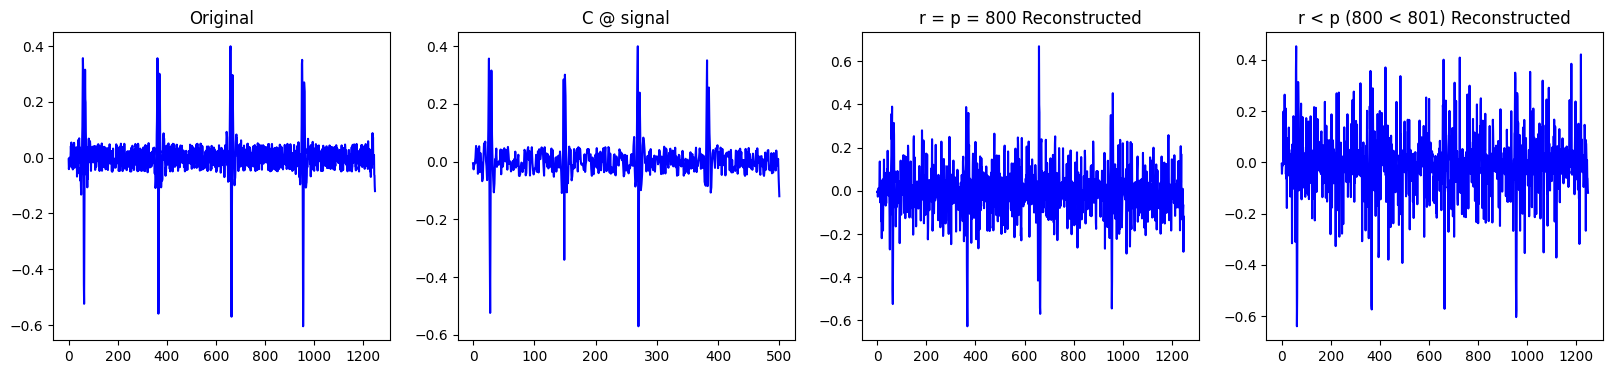

In [89]:
r = 800
p = r
problemSetupEqual = problemSetup
problemSetupOne = processData(fullTrainSignalMatrix, "full", r, p+1)
test, fi = getRandomAlignedSignal()
mseFinal, x_zero = measureAndReconstruct(problemSetupEqual, test)
mseFinal, x_one = measureAndReconstruct(problemSetupOne, test)
fig, ax = plt.subplots(1,4, figsize=(20,4))
style = getStyle(fi)
ax[0].plot(test, style)
ax[0].set_title("Original")

ax[1].plot(test[sorted(problemSetup.pivots)], style)
ax[1].set_title("C @ signal")
print(weird(x_zero))
ax[2].plot(x_zero, style)
ax[2].set_title(f"r = p = {r} Reconstructed")

ax[3].plot(x_one, style)
ax[3].set_title(f"r < p ({r} < {p+1}) Reconstructed")

plt.savefig("panhelp.png")
plt.show()

In [87]:
problemSetupEqual.truncSVD.U.shape, problemSetupEqual.truncSVD.S.shape, problemSetupEqual.truncSVD.VT.shape, 1176 in pivots

((1250, 500), (500, 500), (500, 24588), True)

# Random Dropout (Static Mask)

In [77]:
def random_drop_mask(keep_percentage, length=1250):
    """ CLAUDE
    Randomly drop data points from a NumPy array.
    
    :param data: Input NumPy array
    :param keep_percentage: Percentage of data points to keep (0-100)
    :return: Filtered NumPy array with the desired percentage of data points
    """
    if not 0 < keep_percentage <= 100:
        raise ValueError("Keep percentage must be between 0 and 100")
    
    # Generate a binary mask with the desired probability of keeping each element
    keep_mask = np.random.binomial(1, keep_percentage / 100, size=length).astype(bool)
    
    # Apply the mask to the original data
    #filtered_data = data[keep_mask]
    
    return keep_mask
    
def randomDropout(keep_percent = 50, trunc = True):
    mask = random_drop_mask(keep_percent)
    print(f"keep: {keep_percent}%. mask: {np.sum(mask)}") 

    for fi in tqdm(directory_files, desc="Static Random Mask"): #special iterator that makes a progress bar
        temp = np.loadtxt(os.path.join(dir_path,fi))
        dropped = None
        if trunc:
            dropped = temp[mask]
        else:
            dropped = np.where(mask, temp, 0)
        
        outName = os.path.join(r'C:\Users\jodge\Documents\School\Summer24\drop_data', 'D' + fi)
        np.savetxt(outName, dropped, fmt='%.7f')
    
    print("DONE")
    return np.sum(mask) # how many data points were kept (should be close to 1250 * keep percent)


In [78]:
keeping = 8.56 #kep 50%
trunc = False
mod = "original"
if mod == "original":
    trunc = False
masklen = randomDropout(keeping, trunc)
length = masklen if trunc else 1250    

keep: 8.56%. mask: 127


Static Random Mask:   2%|█▏                                                       | 605/30213 [00:02<01:48, 272.91it/s]


KeyboardInterrupt: 

In [ ]:
keeping = str(keeping).replace('.','-')  
ans, bat_name = batGen(masklen, mode = "drop", length = length, model = "original", kept = keeping)
print(bat_name)

# Random Dropout

In [ ]:
keep_percentage = 50
longest = 0
model = 'original'
trunc = True
if model == 'original':
    trunc = False

for fi in tqdm(directory_files[:], desc=f"Totally Random {keep_percentage}%"): #special iterator that makes a progress bar
    temp = np.loadtxt(os.path.join(dir_path,fi))
    temp_mask = np.random.binomial(1, keep_percentage / 100, size=1250).astype(bool)
    temp_len = np.sum(temp_mask)
    longest = temp_len if temp_len > longest else longest
    
    if trunc:
        dropped = temp[temp_mask]
    else:
        dropped = np.where(temp_mask, temp, 0)
        
    outName = os.path.join(r'C:\Users\jodge\Documents\School\Summer24\drop_data', fi)
    np.savetxt(outName, dropped, fmt='%.7f')

keep_percentage = str(keep_percentage).replace('.','-')
out_train_name = f'train_rand_k{keep_percentage}_l{longest}_{model}.txt'
out_test_name = f'TEST_rand_k{keep_percentage}_l{longest}_{model}.csv'
data_folder = 'drop_data\\'
bat_name = batGenNew(out_train_name, out_test_name, numRuns = 5, indices_folder = None, data_folder=data_folder, length=longest, model = 'avgpool')
bat_name

# FFT

In [79]:
def fftMask(ranks = 250):
    pkl_name = "fftMask" + str(ranks) + ".pkl"
    pkl_loc = os.path.join("data", pkl_name)
    mask = None

    if os.path.exists(pkl_loc):
        mask = readObj(pkl_loc)
    else:
        temp = np.fft.rfft(np.loadtxt(os.path.join(dir_path,directory_files[0])))
        counts = np.zeros_like(temp)
        print()
        for fi in tqdm(directory_files, desc = f"Generating FFT mask of {ranks} ranks."):
            temp = np.loadtxt(os.path.join(dir_path,fi))
            fft = np.fft.rfft(temp)
            
            ranked = np.argsort(np.abs(fft))[::-1]
            top_indices = ranked[:ranks]
            counts[top_indices] += 1
        #print(f"counts {counts}")
        
        plt.plot(counts)
        plt.title("counts")
        plt.show()
            
        final_indices = np.argsort(counts)[-ranks:]
        #print(f"{len(final_indices)} final idxs: {final_indices}")
        mask = np.zeros_like(counts, dtype=bool)
        mask[final_indices] = True
        saveObj(mask, pkl_loc)
        
    print(f"mask of len {len(mask)} ready")
    return mask

def fftSparseGen(mask, ranks, trunc = False):
    for fi in tqdm(directory_files, desc="Files Processing"):
        temp = np.loadtxt(os.path.join(dir_path,fi))
        fft = np.fft.rfft(temp)

        if trunc:
            done = fft[:][mask]
        else: # zeroes otherwise
            done = np.where(mask, fft, 0) 
        #print(len(done))
        
        outName = os.path.join(r'C:\Users\jodge\Documents\School\Summer24\fft_data', 'F' + fi)
        np.savetxt(outName, done.real, fmt='%.7f')
    
    print("DONE")

In [ ]:
bandpass_mask = np.zeros(626, dtype=bool)
pass_band_filter = list(range(15*5,55*5))
bandpass_mask[pass_band_filter] = True

ranks = len(pass_band_filter)
truncate = True
#fftSparseGen(fftMask(ranks), ranks, trunc = truncate)
fftSparseGen(bandpass_mask, ranks, trunc = truncate)

In [ ]:
len_temp = ranks if truncate else 1250
ans, bat_name = batGen(ranks, mode = "fft", length = len_temp, model = "avgpool")
print(bat_name)

# Wavelet

In [80]:
def basicDWTProcess(w='db4', m='zero'):
    data = np.loadtxt(os.path.join(dir_path,directory_files[1]))
    cA, cD = pywt.dwt(data, wavelet=w, mode=m)
    size = len(cA)
    
    for fi in tqdm(directory_files, desc="Files Processing"):
        data = np.loadtxt(os.path.join(dir_path,fi))
        cA, cD = pywt.dwt(data, wavelet=w, mode=m)
        outName = os.path.join(r'C:\Users\jodge\Documents\School\Summer24\temp_data', fi)
        np.savetxt(outName, cA, fmt='%.7f')
    
    return size #return length after processing
    
def waveletDecomp(w='db4', m='zero', l=5, r=3):
    data = np.loadtxt(os.path.join(dir_path,directory_files[1]))
    coeffs = pywt.wavedec(data, w, mode=m, level=l)
    #print(coeffs[r])
    size = len(coeffs[r])
    
    for fi in tqdm(directory_files, desc=f"{w} {m} {l}"):
        data = np.loadtxt(os.path.join(dir_path,fi))
        coeffs = pywt.wavedec(data, w, mode=m, level=l)
        outName = os.path.join(r'C:\Users\jodge\Documents\School\Summer24\temp_data', fi)
        np.savetxt(outName, coeffs[r], fmt='%.7f')
    
    return size #return length after processing  

### simple DWT

In [ ]:
w = 'db12'
m = 'zero'
length = basicDWTProcess(w,m)

mod = 'avgpool'
out_train_name = f'train_dwt_{w}_{m}_r{length}_l{length}_{mod}.txt'
out_test_name = f'TEST_dwt_{w}_{m}_r{length}_l{length}_{mod}.csv'

data_folder = "temp_data\\"

bat_name = batGenNew(out_train_name, out_test_name, numRuns = 5, data_folder=data_folder, model = mod, length=length)
bat_name

### configurable wavelet decomp

In [ ]:
w = 'coif3' # wavelet_list = ['db4', 'db6', 'db8', 'sym4', 'sym6', 'sym8', 'coif3', 'coif4', 'bior3.3', 'bior3.5']

m = 'zero' # zero symmetric periodic
levels = 5
wanted = 3 #informed by waveletMaskCounter, seems to always be 3 at level 5 decomp
length = waveletDecomp(w,m,l=levels,r=wanted)

size = 98 if length < 98 else length

mod = 'original'
w = w.replace('.','-')
file_setup = f'{w}_{m}_{levels}-{wanted}_r{length}-{size}_{mod}'
out_train_name = f'train_{file_setup}.txt'
out_test_name = f'TEST_{file_setup}.csv'

data_folder = "temp_data\\"

bat_name = batGenNew(out_train_name, out_test_name, numRuns = 10, data_folder=data_folder, model = mod, length=length)
bat_name

# Short Time Length

### note that on a model (avgpool) that accepts shorter than 1250 length inputs, you can just use the --size arg when running (hence "trunc" will be False by default)

In [81]:
def shortenFiles(length, trunc = False):
    
    for fi in tqdm(directory_files, desc=f"Shortening Data {length}/1250"):
        data = np.loadtxt(os.path.join(dir_path,fi))
        data = data[:length]
        outName = os.path.join(r'C:\Users\jodge\Documents\School\Summer24\temp_data', fi)
        np.savetxt(outName, data, fmt='%.7f')

In [32]:
mod = 'original'
points = 1150

additional_flags = ''
if mod == 'original':
    length = 1250
else:
    length = points
    additional_flags = f'--size {length}'

shortenFiles(points, False)

out_train_name = f'train_short_{points}_{length}_{mod}.txt'
out_test_name = f'TEST_short_{points}_{length}_{mod}.csv'

data_folder = "temp_data\\"

bat_name = batGenNew(out_train_name, out_test_name, numRuns = 5, data_folder=data_folder, model = mod, length=length, additional_flags=additional_flags)
bat_name

Shortening Data 1150/1250: 100%|████████████████████████████████████████████████| 30213/30213 [01:47<00:00, 280.58it/s]


'short_1150_1250_original.bat'

# Final Idea
### Half Sample Rate, Half Length, DWT db4 zero cA

In [82]:
def assemblage(sample_rate = 2, length_percent = 625/1250, wavelet = 'db12', padding = 'zero'):
    size = 0
    for fi in tqdm(directory_files, desc=f"Assemblage"):
        data = np.loadtxt(os.path.join(dir_path,fi))
        n = len(data)
        
        data = data[:int(n * length_percent)]
        data = data[::sample_rate]
        cA, cD = pywt.dwt(data, wavelet=wavelet, mode=padding)
        
        size = len(cA)
        outName = os.path.join(r'C:\Users\jodge\Documents\School\Summer24\temp_data', fi)
        np.savetxt(outName, cA, fmt='%.7f')
    
    return size #return length after processing

In [ ]:
mod = 'avgpool'

sample_rate = 2
length_percent = 625/1250
wavelet='db4'
padding='zero'
epochs = 2

length = assemblage()


In [ ]:
if mod == 'original':
    length = 1250

out_train_name = f'train_assemblage_sr{sample_rate}_len{length_percent*100}_{wavelet}_{padding}_cA_fs{length}_{mod}.txt'
out_test_name = f'TEST_assemblage_sr{sample_rate}_len{length_percent*100}_{wavelet}_{padding}_cA_fs{length}_{mod}.csv'

data_folder = "temp_data\\"
additional_flags = '' if epochs == 2 else f'--epoch {epochs}'

bat_name = batGenNew(out_train_name, out_test_name, numRuns = 10, data_folder=data_folder, model = mod, length=length, additional_flags=additional_flags)
bat_name

# Plotting Different Data Manipulations

In [83]:
import random
def getRandomCategorySignal(cat = 'SR'):
    if cat not in label_dict.keys():
        return None
    idx = random.randint(0, len(directory_files))
    file_name = directory_files[idx]
    is_cat = file_name.split('-')[1] == cat
    if is_cat:
        file_path = os.path.join(dir_path, file_name)
        x1 = np.loadtxt(file_path)
        return x1, file_name
    else:
        return getRandomCategorySignal(cat)
        
def getRandomAlignedSignal(good = True): #dnd joke function name
    idx = random.randint(0, len(directory_files))
    file_name = directory_files[idx]
    is_good = file_name.split('-')[1] not in BAD
    if is_good == good:
        file_path = os.path.join(dir_path, file_name)
        x1 = np.loadtxt(file_path)
        return x1, file_name
    else:
        return getRandomAlignedSignal(good)

def plotForms(signal, file_name, problemSetup, r, p):
    #Original, Reduced Rate, Short, Random Drop full, Random Drop trunc, FFT, SVD trunc, SVD recon, Wavelet cA, Wavelet deep
    fix, axs = plt.subplots(5,2, figsize=(12,18))
    style = getStyle(file_name)
    x = range(1250)

    axs[0,0].plot(signal, style)
    axs[0,0].set_title(f'Original: {file_name}')
    
    #Sample Rate
    sr = 4
    downsampled = signal[::sr]
    axs[0,1].plot(downsampled, style)
    axs[0,1].set_title(f'Downsampled: 1/{sr}')

    #Length
    length = 500
    shortened = signal[:length]
    axs[1,0].plot(range(length), shortened, style)
    axs[1,0].set_title(f'Shortened: {length}/{len(signal)}')

    #Random Drop (Static Mask)
    keep_percent = 500/1250 * 100
    mask = random_drop_mask(keep_percent)
    trunc_dropped = signal[mask]
    full_dropped = np.where(mask, signal, 0)
    axs[2,0].plot(trunc_dropped, style)
    axs[2,0].set_title(f'Random Drop Mask (Trunc): {keep_percent}%')
    axs[2,1].plot(full_dropped, style)
    axs[2,1].set_title(f'Random Drop Mask (Full): {keep_percent}%')

    #FFT
    #freqs = 125
    #fftmask = fftMask(freqs)
    # BUT since it's cheap to do so - we'll plot the whole thing
    fft = np.fft.rfft(signal)
    N = len(signal)
    SAMPLE_RATE = 250 # const
    frequencies = np.fft.rfftfreq(N, d=1/SAMPLE_RATE)

    axs[1,1].plot(frequencies, np.abs(fft), style)
    axs[1,1].set_title(f'FFT: (15-55Hz Bandpass)')
    axs[1,1].set_xlim(10, 60)
    
    #SVD
    problemSetupsDir = r'C:\Users\jodge\Documents\School\Summer24\playground\data'
    #r = 500
    #p = 500
    problemSetup = processData(getFullTrainSignalMatrix(), "full", r = r, p = p)
    mse, recon = measureAndReconstruct(problemSetup, signal)
    #print(recon)
    #trunc = problemSetup.C @ signal
    trunc = signal.copy()
    pivs = problemSetup.pivots[:p]
    indices_to_zero = np.setdiff1d(np.arange(trunc.size), pivs)
    np.put(trunc, indices_to_zero, 0)
    axs[3,0].plot(trunc, style)
    axs[3,0].set_title(f'SVD/QR Trunc (With Zeros): r:{r} p:{p}')
    axs[3,1].plot(recon, style)
    axs[3,1].set_title(f'SVD/QR Recon: r:{r} p:{p}')

    #Wavelets
    w = 'db4' #some others are good, db12, coif3
    mode = 'zero' #usually this is the best
    #cA
    cA, cD = pywt.dwt(signal, wavelet=w, mode=mode)
    #Wavelet Multilevel
    coeffs = pywt.wavedec(signal, w, mode=mode, level=5)
    deep_wavelet = coeffs[3]
    axs[4,0].plot(cA, style)
    axs[4,0].set_title(f'Wavelet cA {w} {mode}')
    axs[4,1].plot(deep_wavelet, style)
    axs[4,1].set_title(f'Wavelet 5-3 {w} {mode}')
    plt.savefig(os.path.join("signalcharts",file_name + ".png"))
    plt.show()

reading from data\fullTrainMat.pkl
reading from data\full_r500_p501.pkl
reading from data\fullTrainMat.pkl
reading from data\full_r500_p501.pkl


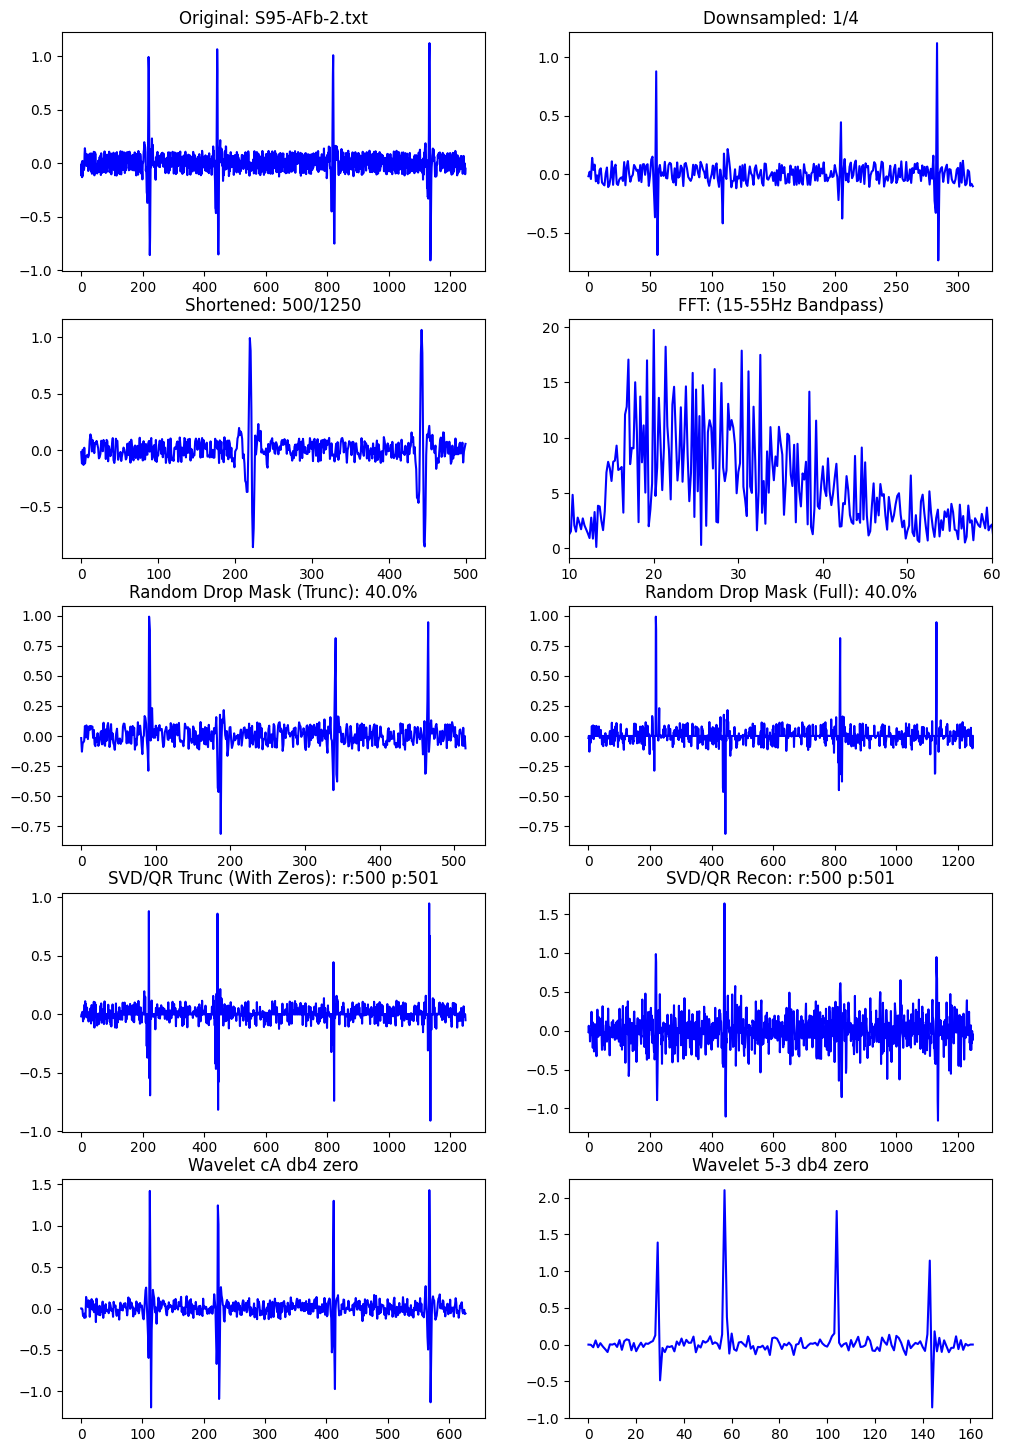

reading from data\fullTrainMat.pkl
reading from data\full_r500_p501.pkl


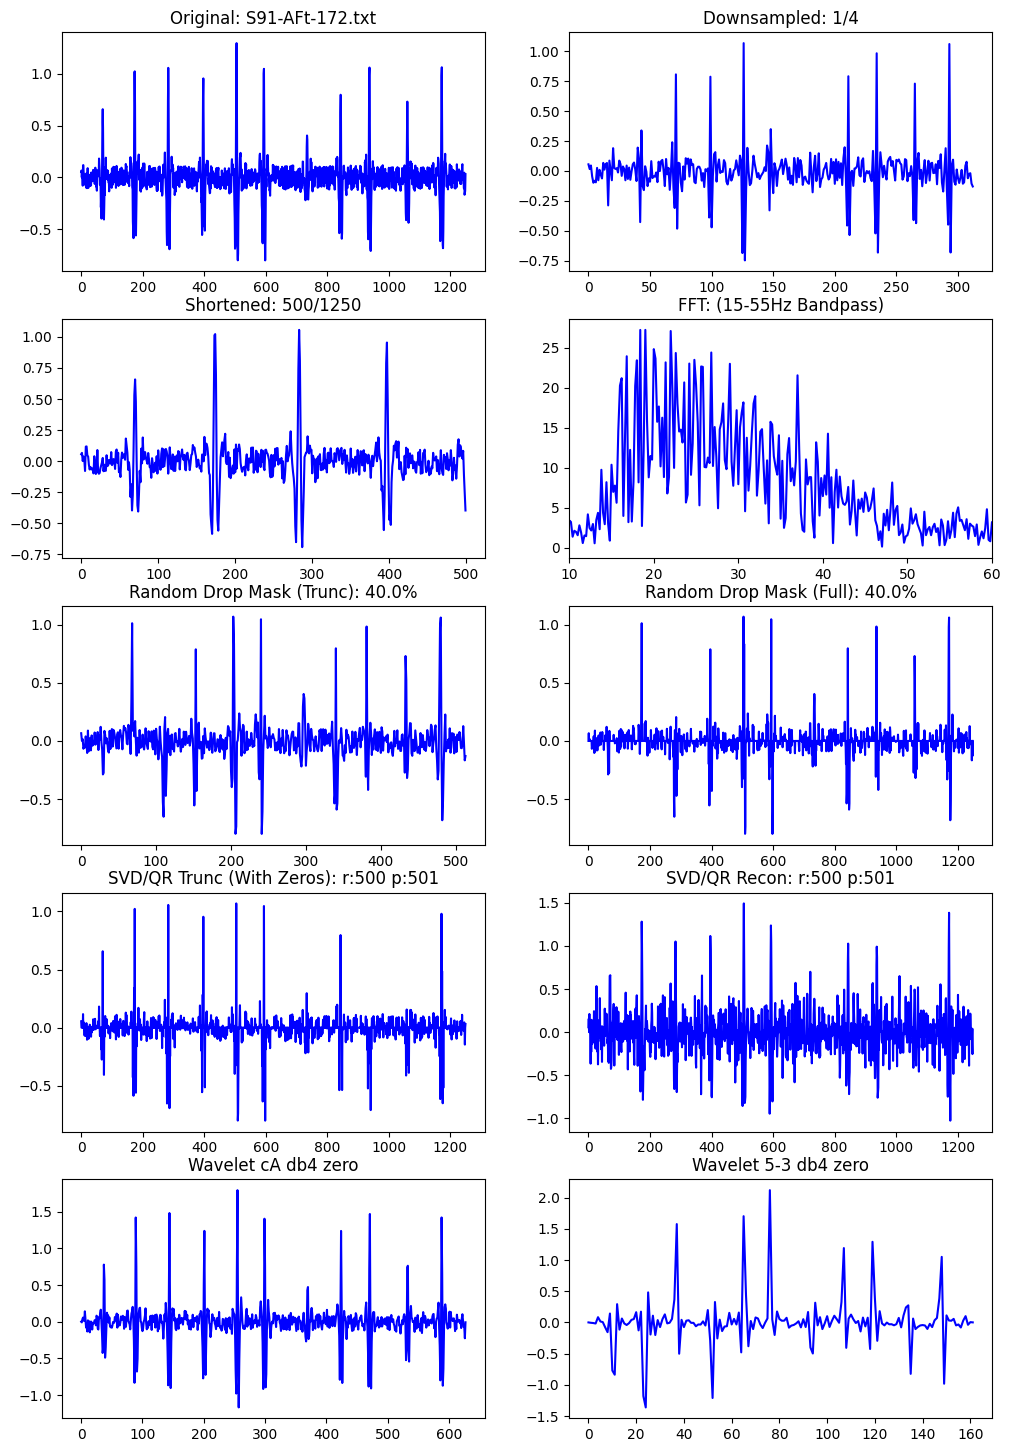

reading from data\fullTrainMat.pkl
reading from data\full_r500_p501.pkl


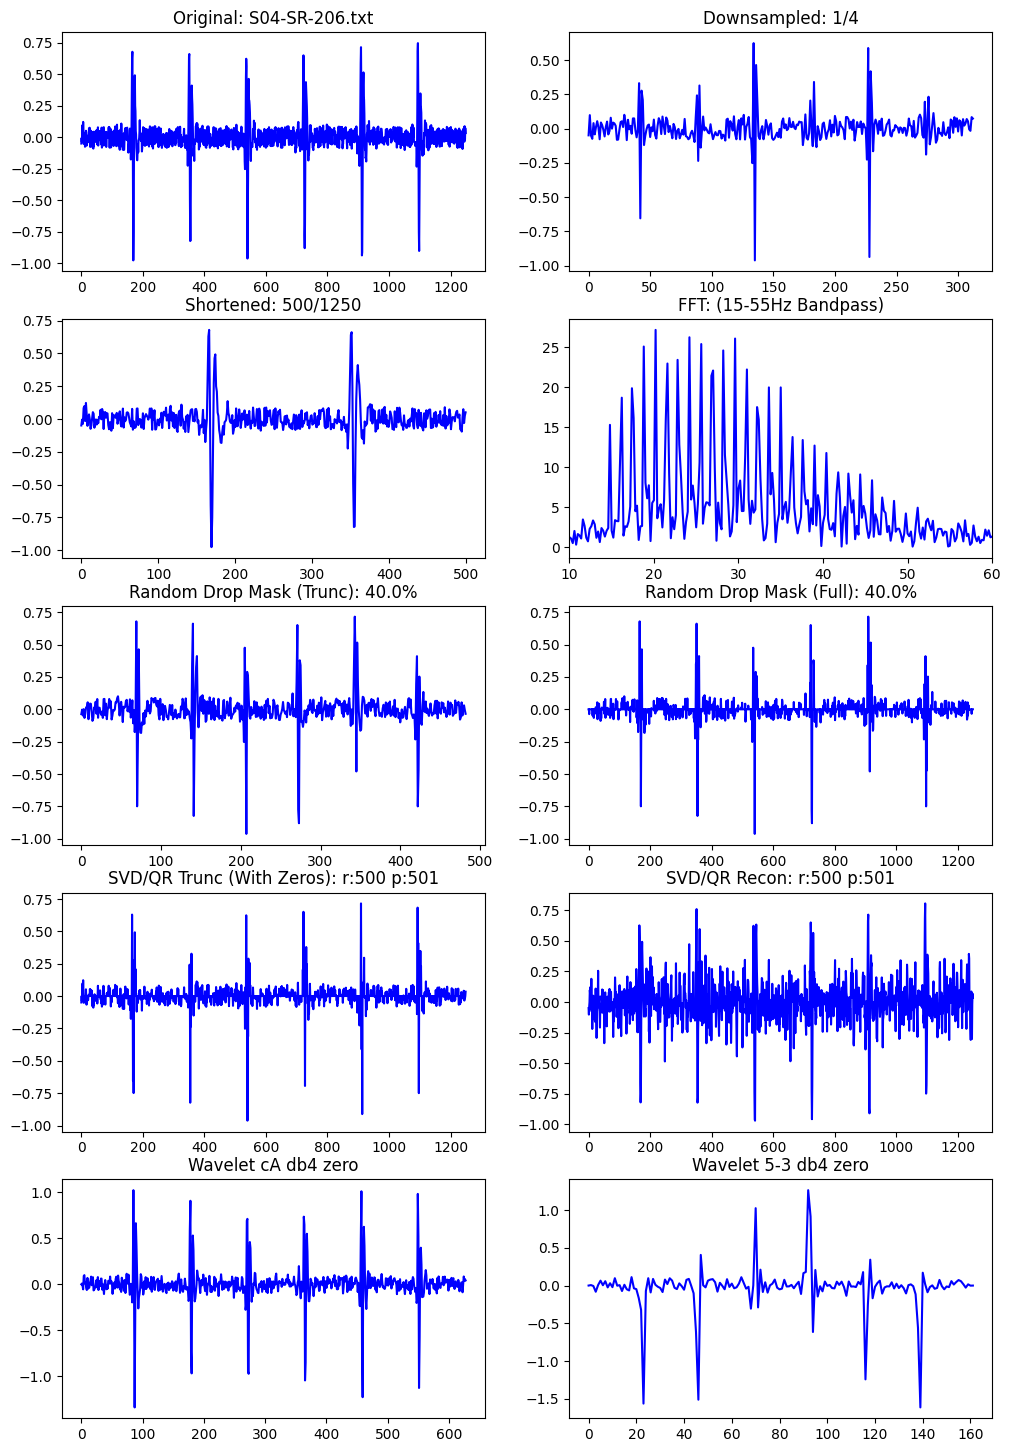

reading from data\fullTrainMat.pkl
reading from data\full_r500_p501.pkl


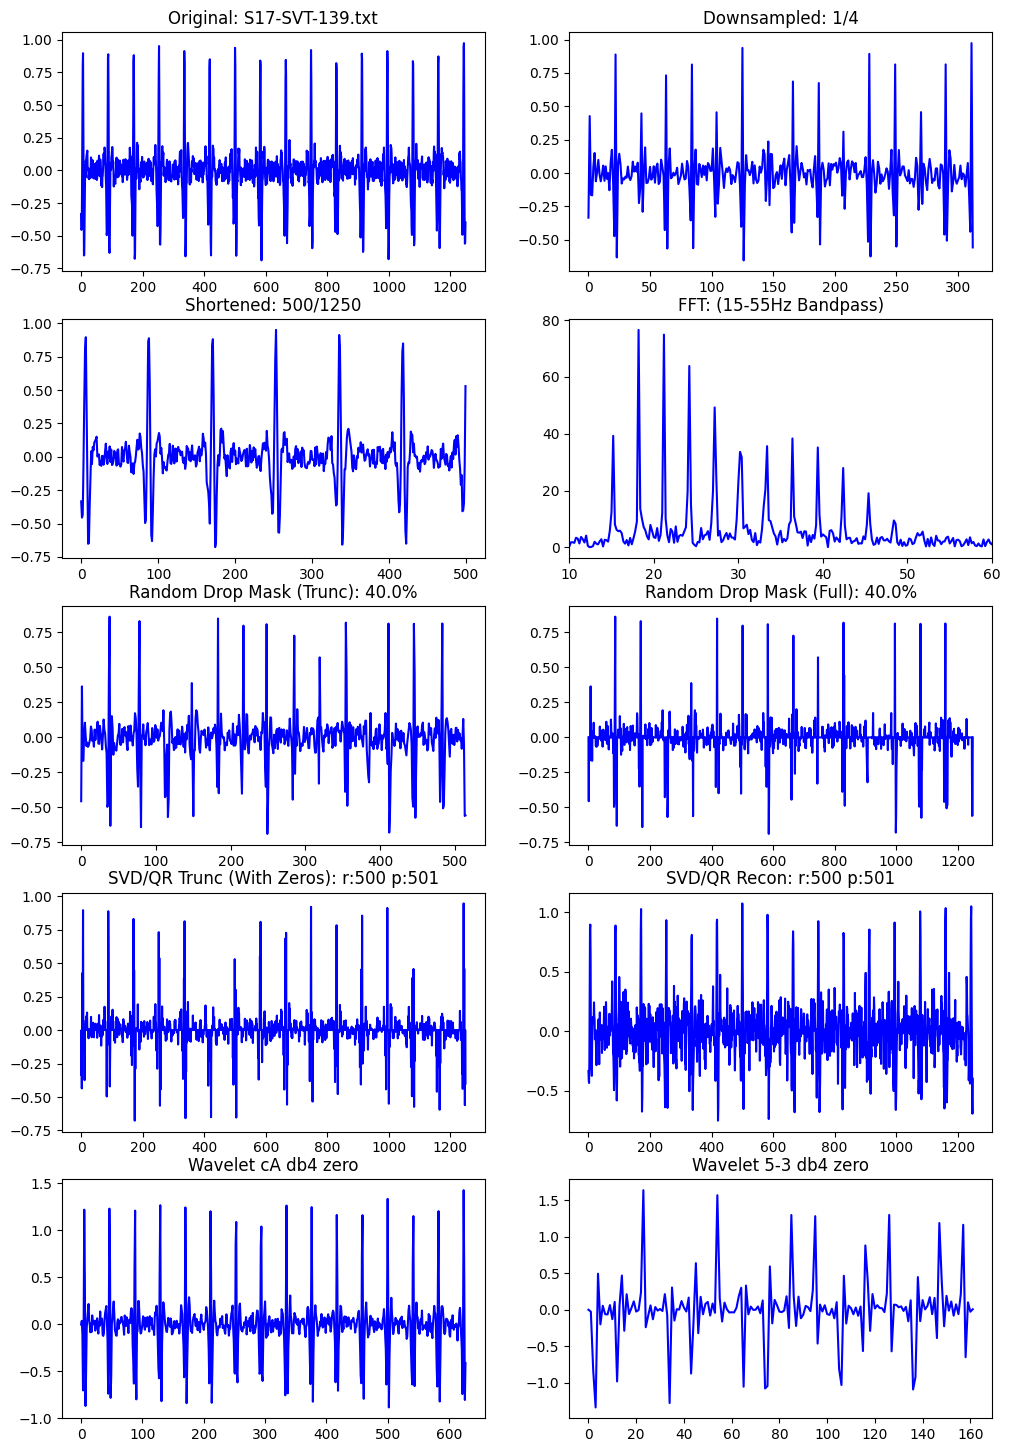

reading from data\fullTrainMat.pkl
reading from data\full_r500_p501.pkl


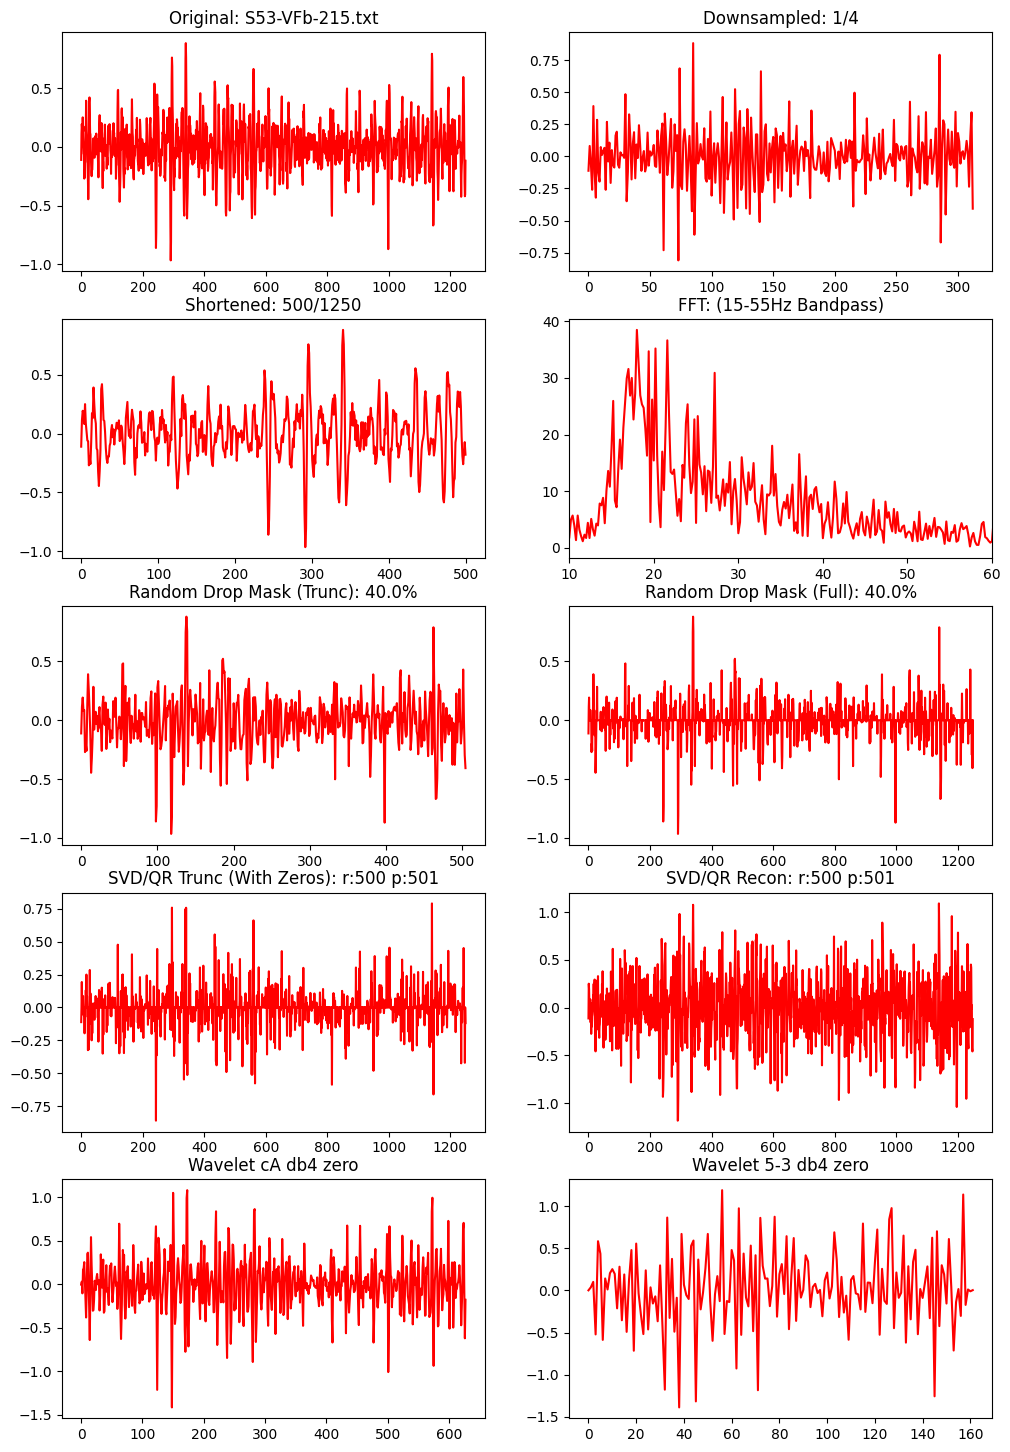

reading from data\fullTrainMat.pkl
reading from data\full_r500_p501.pkl


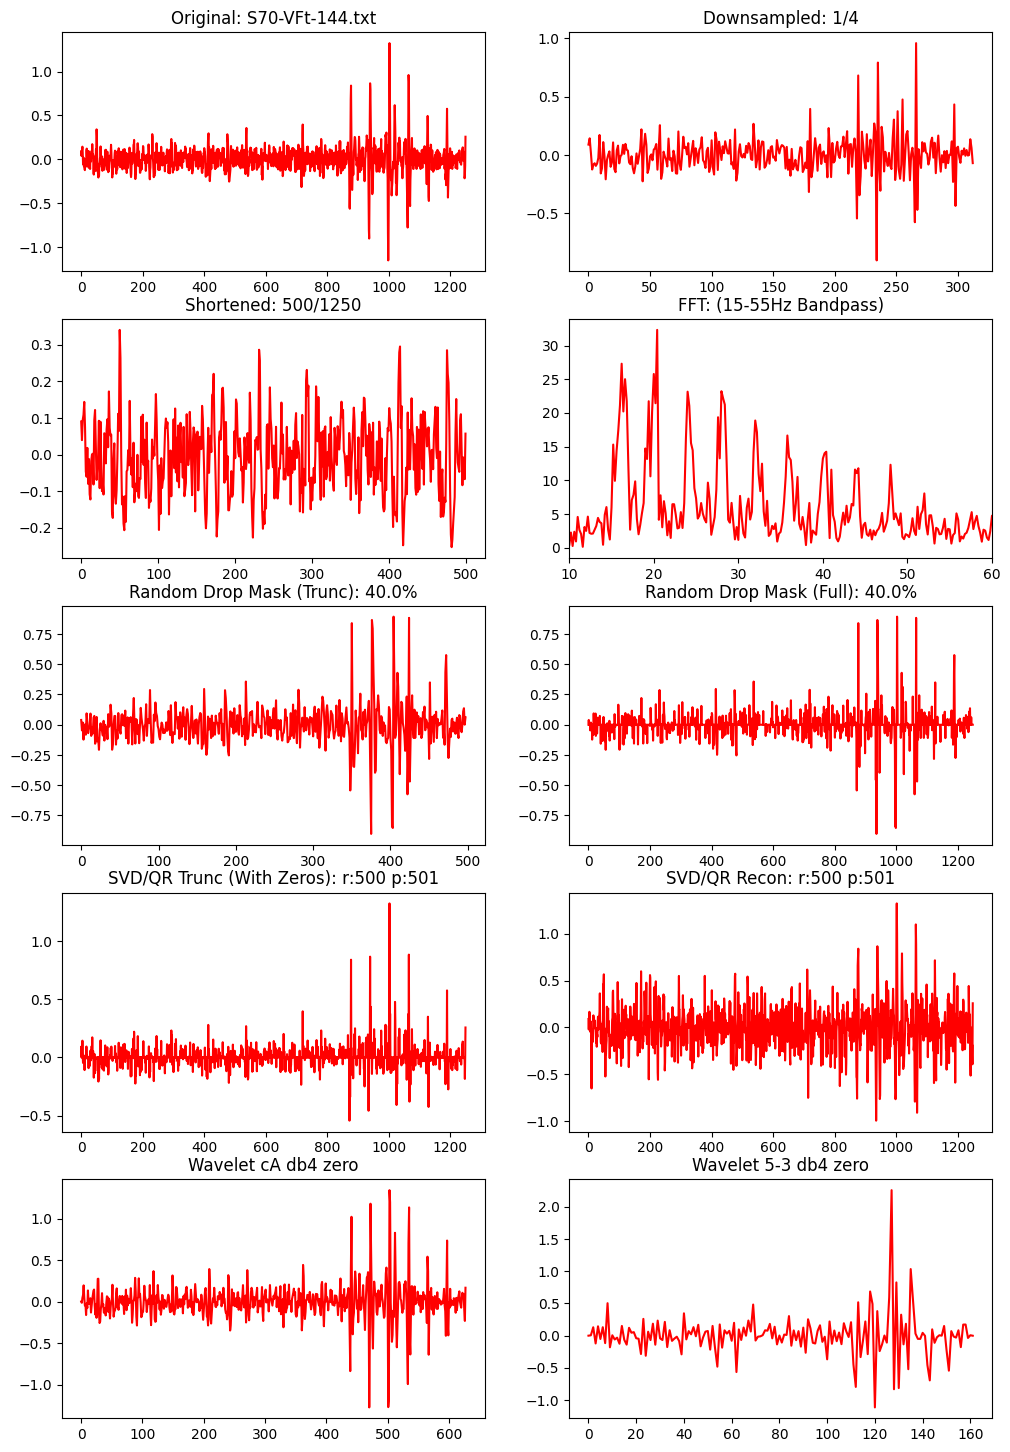

reading from data\fullTrainMat.pkl
reading from data\full_r500_p501.pkl


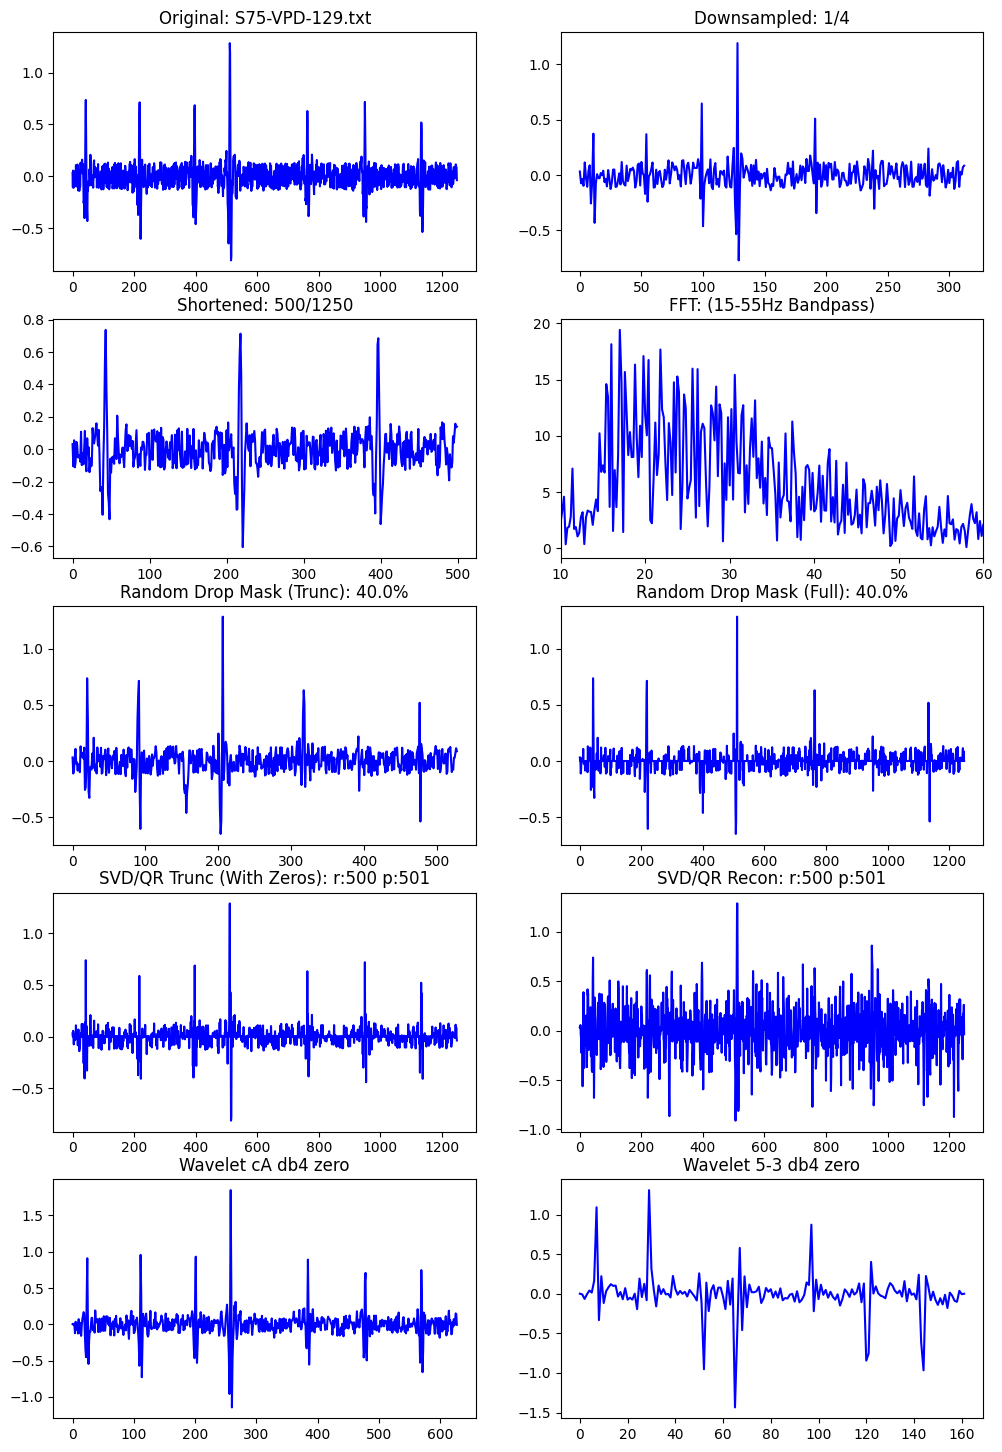

reading from data\fullTrainMat.pkl
reading from data\full_r500_p501.pkl


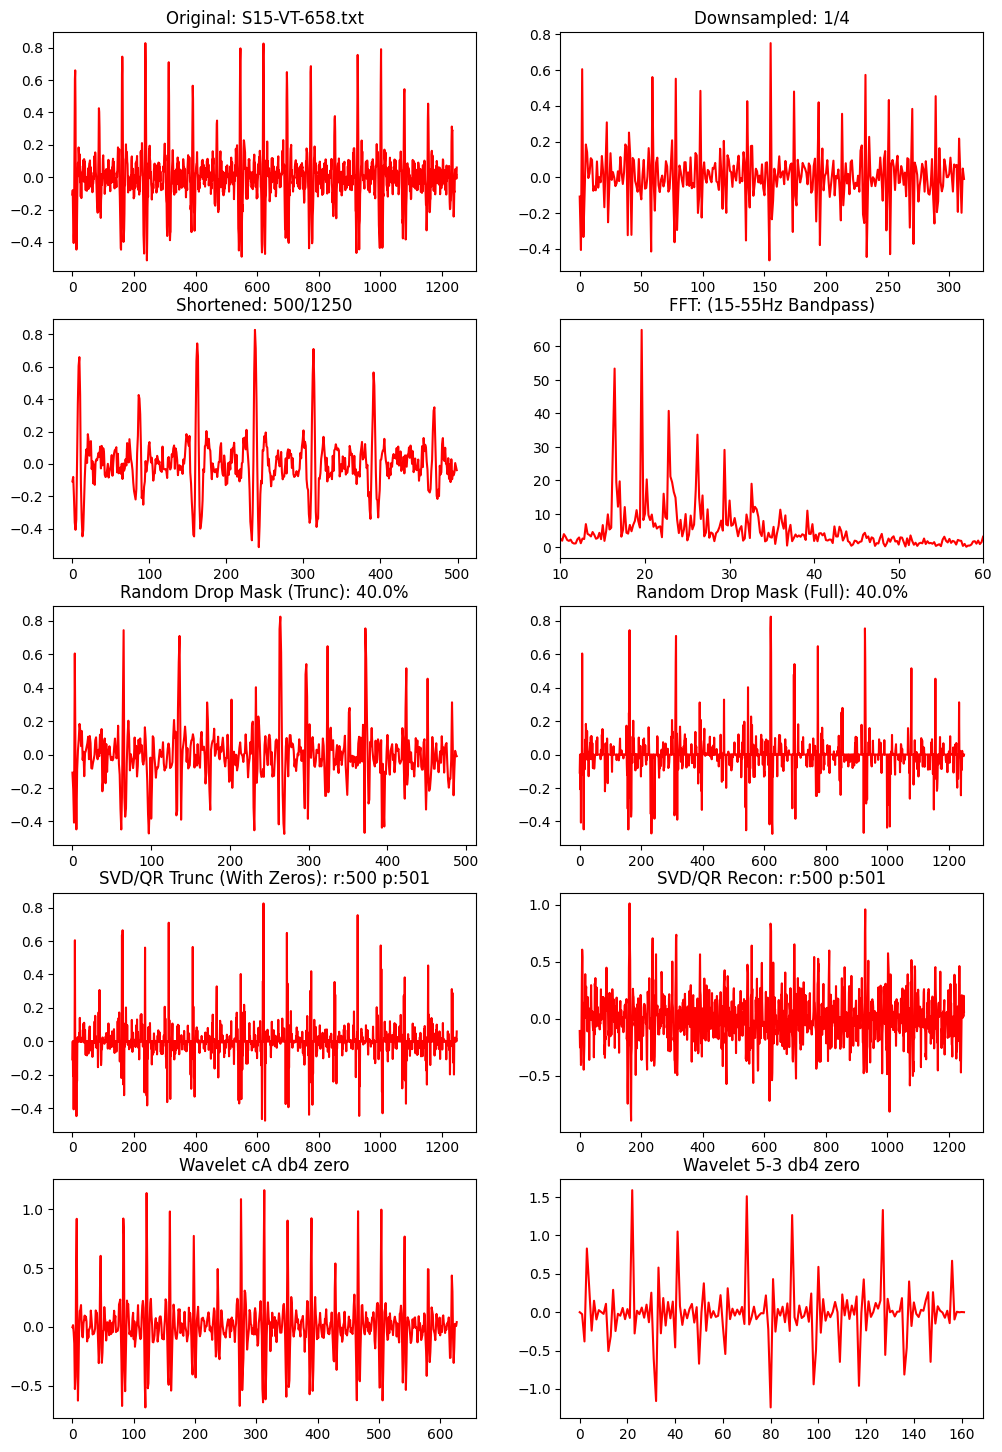

In [84]:
r = 500
p = 501
problemSetup = processData(getFullTrainSignalMatrix(), "full", r = r, p = p)
#print(problemSetup.pivots)
for cat in label_dict.keys():
    signal, file_name = getRandomCategorySignal(cat)
    plotForms(signal, file_name, problemSetup, r, p)

# Help us, Obi-Chen Pan-obi! You're our only hope! - ideally this would be in another notebook

In [34]:
trainingData = getFullTrainSignalMatrix()

U, S, VT = np.linalg.svd(trainingData, full_matrices=False) #full_matrices=False
S = np.diag(S)

print(f"U {U.shape} S {S.shape} VT {VT.shape}")

r = 1245 #rank of tailored basis
p = 1246 #number of sensors / measurements

U_hat, S_hat, VT_hat = U[:,:r], S[:r,:r], VT[:r,:]

print("U shapes ", U.shape, U_hat.shape, (U_hat @ U_hat.T).shape)

Q, R, pivots = None, None, None
if (p == r):
    Q, R, pivots = qr(U, pivoting = True)
elif (p > r): # oversampled
    Q, R, pivots = qr(U_hat @ U_hat.T, pivoting = True)

print(f"QRP {Q.shape} {R.shape} {pivots.shape}")
        
pivots = pivots[:p] #this tells us where to place our "sensors"
#print(max(pivots), pivots)

C = np.zeros((p, trainingData.shape[0])) # measurement matrix (p x 1250)
C[np.arange(p), pivots] = 1

print(f"Q {Q.shape} R {R.shape} pivots {pivots.shape} C {C.shape}")
pivots[:10], C[:10]

reading from data\fullTrainMat.pkl
U (1250, 1250) S (1250, 1250) VT (1250, 24588)
U shapes  (1250, 1250) (1250, 1245) (1250, 1250)
QRP (1250, 1250) (1250, 1250) (1250,)
Q (1250, 1250) R (1250, 1250) pivots (1246,) C (1246, 1250)


(array([ 636, 1103,  382, 1171,  235,  792, 1179,  979,  756,  927],
       dtype=int32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [ ]:
training = getFullDataTrainingMatrix()

In [35]:
signal, filename = getRandomAlignedSignal()
y = C @ signal
print(y.shape, p, r)

padded = signal.copy()
pivs = pivots
indices_to_zero = np.setdiff1d(np.arange(padded.size), pivots)
np.put(padded, indices_to_zero, 0)

# Solve for coefficients
U_k_reduced = U_hat[:, :p][pivots, :] # suggested to try
#print("cond", np.linalg.cond(U_k_reduced), np.linalg.cond(U_hat))

if p == r:
    #a = np.linalg.lstsq(U_k_reduced, y, rcond=None)[0]
    a = np.linalg.solve(C @ U_hat, y)
    #a = np.linalg.pinv(U_k_reduced) @ y
    #a = np.linalg.inv(C @ U_hat) @ y
    #a = np.linalg.lstsq(C @ U_hat, y, rcond=None)[0]
else:
    a = np.linalg.pinv(C @ U_hat) @ y

x_reconstructed = U_hat @ a
mseFinal = np.mean((signal - x_reconstructed) ** 2)

(1246,) 1246 1245


In [62]:
#training = getFullTrainSignalMatrix()
r = 1245
#problemSetupEqual = processData(training, "full", r, r)
#problemSetupOver = processData(training, "full", r, r+1)
randsig, filename = getRandomAlignedSignal()

mse_eq, xr_eq = measureAndReconstruct(problemSetupEqual, randsig)
mse_ov, xr_ov = measureAndReconstruct(problemSetupOver, randsig)

1184


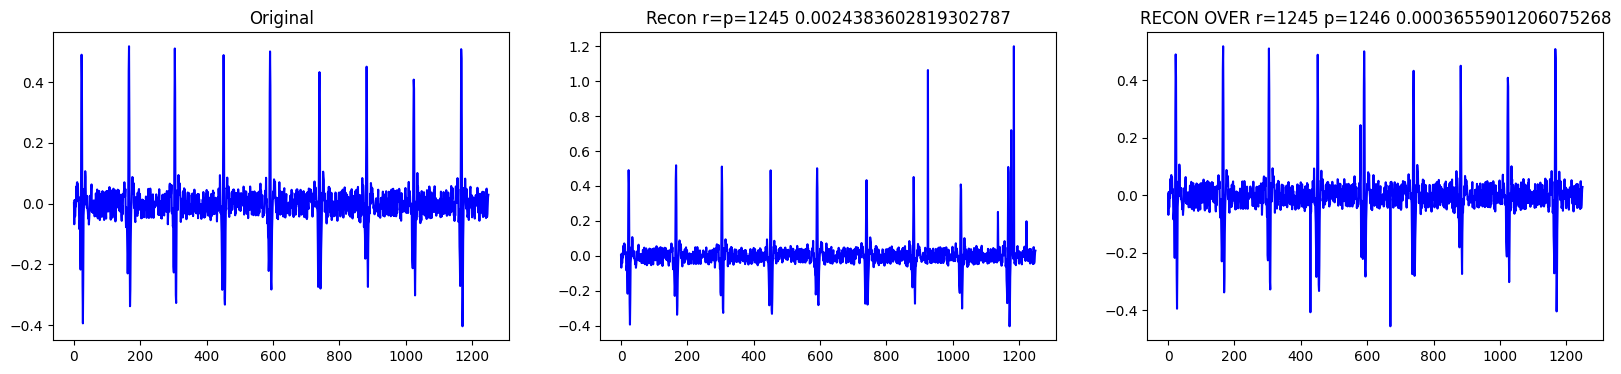

In [63]:
fig, ax = plt.subplots(1,3, figsize=(20,4))
style = getStyle(filename)
ax[0].plot(randsig, style)
ax[0].set_title("Original")

trunc = signal[sorted(pivs)]
print(weird(xr_eq))
ax[1].plot(xr_eq, style)
ax[1].set_title(f"Recon r=p={r} {mse_eq}")

ax[2].plot(xr_ov, style)
ax[2].set_title(f"RECON OVER r={r} p={r+1} {mse_ov}")
plt.savefig("success1.png")
plt.show()

### 